In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd

In [162]:
# Read data as DataFrame
df_data = pd.DataFrame(pd.read_csv('Google_Stock_Price_Train.csv',thousands=','))
df_data.drop(columns='Date',inplace=True)
df_data.drop(columns='Volume',inplace=True)
# 2-561 -> 0-559
# 'Close' from [0,559] divided by 2
df_data.astype('float')
df_data.loc[0:559, 'Close'] = df_data.loc[0:559, 'Close']/2
df_data

,Open,High,Low,Close
0,325.25,332.83,324.97,331.795
1,331.27,333.87,329.08,333.225
2,329.83,330.75,326.89,328.605
3,328.34,328.77,323.68,324.120
4,322.04,322.29,309.46,310.380
...,...,...,...,...
1253,790.90,792.74,787.28,789.910
1254,790.68,797.86,787.66,791.550
1255,793.70,794.23,783.20,785.050
1256,783.33,785.93,778.92,782.790


In [163]:
training_set = df_data.values
print(training_set)

[[325.25  332.83  324.97  331.795]
 [331.27  333.87  329.08  333.225]
 [329.83  330.75  326.89  328.605]
 ...
 [793.7   794.23  783.2   785.05 ]
 [783.33  785.93  778.92  782.79 ]
 [782.75  782.78  770.41  771.82 ]]


In [164]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [165]:
# Input past 30 days data, [open, high, low, close] * 30 ===> output [close]
# Input size = 30, hidden size = 128, output size = 1
n_hidden = 64
n_input = 4
n_output = 1
n_layers = 1
rnn = RNN(n_input, n_hidden,n_layers, n_output)

In [166]:
n_windows = 30
input = training_set[0]
input = torch.from_numpy(input).float().view(1,1,n_input)
print(input)
print(input.size())
# hidden = torch.zeros(1, n_hidden)
hidden = None
output, next_hidden = rnn(input, hidden)
print(output)
print(output.size())

tensor([[[325.2500, 332.8300, 324.9700, 331.7950]]])
torch.Size([1, 1, 4])
tensor([[-0.4492]], grad_fn=<AddmmBackward>)
torch.Size([1, 1])


In [186]:
learning_rate = 0.005
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hidden = None

In [187]:
def train(inputs, labels):
    
    """
    inputs: 30 day's stock (30,1,4)
    labels: the following day's stock (open) (1,1)
    """
    hidden = None
    
    rnn.zero_grad()
    
    # convert inputs and labels to tensor
    inputs = torch.from_numpy(inputs).float().view(n_windows,1,n_input)
    labels = labels.reshape(1,1)
    labels = torch.from_numpy(labels).float()
    
    
    for i in range(inputs.size()[0]):
        output, hidden = rnn(inputs[0].view(1,1,n_input),hidden)
    
    loss = criterion(output, labels) # output = (1,1)
    loss.backward()
    
    optimiser.step()
    return output, loss.item()

In [188]:
num_epochs = 20
all_losses = []

for epoch in range(num_epochs):
    # Get inputs and labels
    for i in range(n_windows, 1258):
        inputs = training_set[i-n_windows:i]
        labels = training_set[i,3]       # ith row, first col, close price
        output, loss = train(inputs, labels)
    
    
    all_losses.append(loss)
    print('epoch {}, loss {}'.format(epoch+1,loss))

print('Finish')

epoch 1, loss 44487.34375
epoch 2, loss 38652.7265625
epoch 3, loss 36458.1328125
epoch 4, loss 35584.38671875
epoch 5, loss 35265.28125
epoch 6, loss 35146.4765625
epoch 7, loss 35101.890625
epoch 8, loss 35084.64453125
epoch 9, loss 35078.109375
epoch 10, loss 35075.546875
epoch 11, loss 35074.609375
epoch 12, loss 34536.0859375
epoch 13, loss 34494.55859375
epoch 14, loss 34480.25390625
epoch 15, loss 34476.4921875
epoch 16, loss 34475.5859375
epoch 17, loss 34475.3828125
epoch 18, loss 34475.3359375
epoch 19, loss 34475.3359375
epoch 20, loss 34475.3359375
Finish


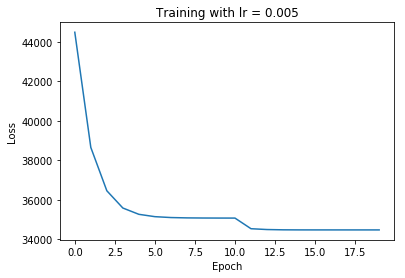

In [193]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.title('Training with lr = 0.005')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(all_losses)

In [190]:
# Test
test_data = pd.DataFrame(pd.read_csv('Google_Stock_Price_Test.csv',thousands=','))
test_data.drop(columns='Date',inplace=True)
test_data.drop(columns='Volume',inplace=True)
test_data.astype('float')
test_set = test_data.values
print(np.shape(test_set))

(50, 4)


In [191]:
output_predict = []
output_true = []
for j in range(n_windows, 50):
    inputs = test_set[j-n_windows:j]
    labels = test_set[j,3]      
    inputs = torch.from_numpy(inputs).float().view(n_windows,1,n_input)
    labels = labels.reshape(1,1)
    labels = torch.from_numpy(labels).float()

    for i in range(inputs.size()[0]):
        output, hidden = rnn(inputs[0].view(1,1,n_input),hidden)
    
    output_predict.append(output)
    output_true.append(labels)

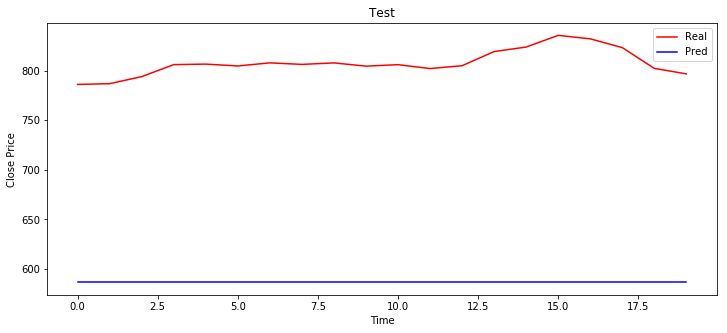

In [192]:
plt.figure(1, figsize=(12, 5))
plt.plot(output_true, color = 'red', label = 'Real')
plt.plot(output_predict, color = 'blue', label = 'Pred')
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()